In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import scipy.stats as stats
import pylab

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv(r"C:\Users\user\OneDrive - iitkgp.ac.in\Desktop\SQL\train.csv")
df.drop(['id', 'Offer %'], axis='columns', inplace=True)

# I temporarily did not drop title column because it helped me understand null values
# Dropped Offer % as it wont be useful to train model and is connected to output price1
print(df.shape)
df.head()

(15730, 14)


,title,Rating,maincateg,platform,price1,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,38.0,7.0,17.0,9.0,6.0,3,3,0
1,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,531.0,69.0,264.0,92.0,73.0,29,73,1
2,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,17.0,4.0,11.0,3.0,2.0,1,0,1
3,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,77.0,3.0,35.0,21.0,7.0,7,7,1


In [4]:
#copy of train.csv just to plot data later

data = pd.read_csv(r"C:\Users\user\OneDrive - iitkgp.ac.in\Desktop\SQL\train.csv")
data.drop('id', axis='columns', inplace=True)

data.head()

,title,Rating,maincateg,platform,price1,actprice1,Offer %,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,30.13%,38.0,7.0,17.0,9.0,6.0,3,3,0
1,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,50.03%,531.0,69.0,264.0,92.0,73.0,29,73,1
2,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,45.01%,17.0,4.0,11.0,3.0,2.0,1,0,1
3,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,15.85%,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,40.02%,77.0,3.0,35.0,21.0,7.0,7,7,1


In [5]:
#Converting offer % columns to float data type
data['Offer %'] = data['Offer %'].str.replace('%', '').astype('float')

# Initial look at data

In [6]:
df.isnull().sum(axis='columns').sum()

3140

~20% rows has null values, I will first do some basic data plots and then handle null values

<AxesSubplot:>

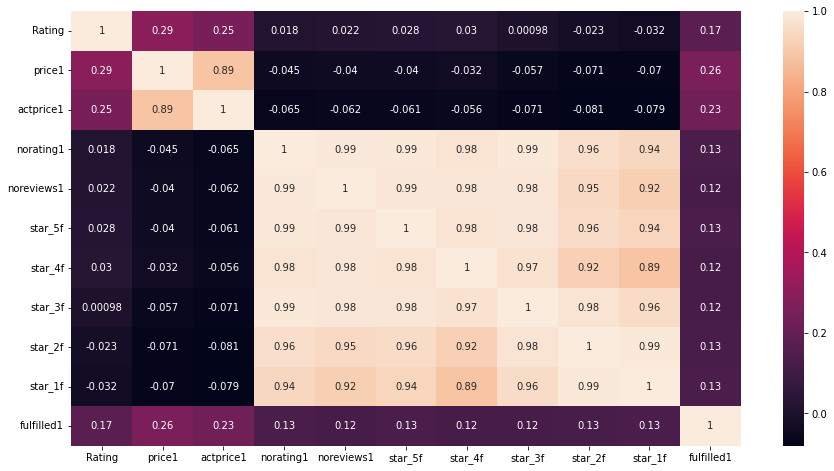

In [7]:
plt.figure(figsize=(15,8))
sns.heatmap(df.drop(['title', 'maincateg', 'platform'], axis='columns').corr(), annot=True)

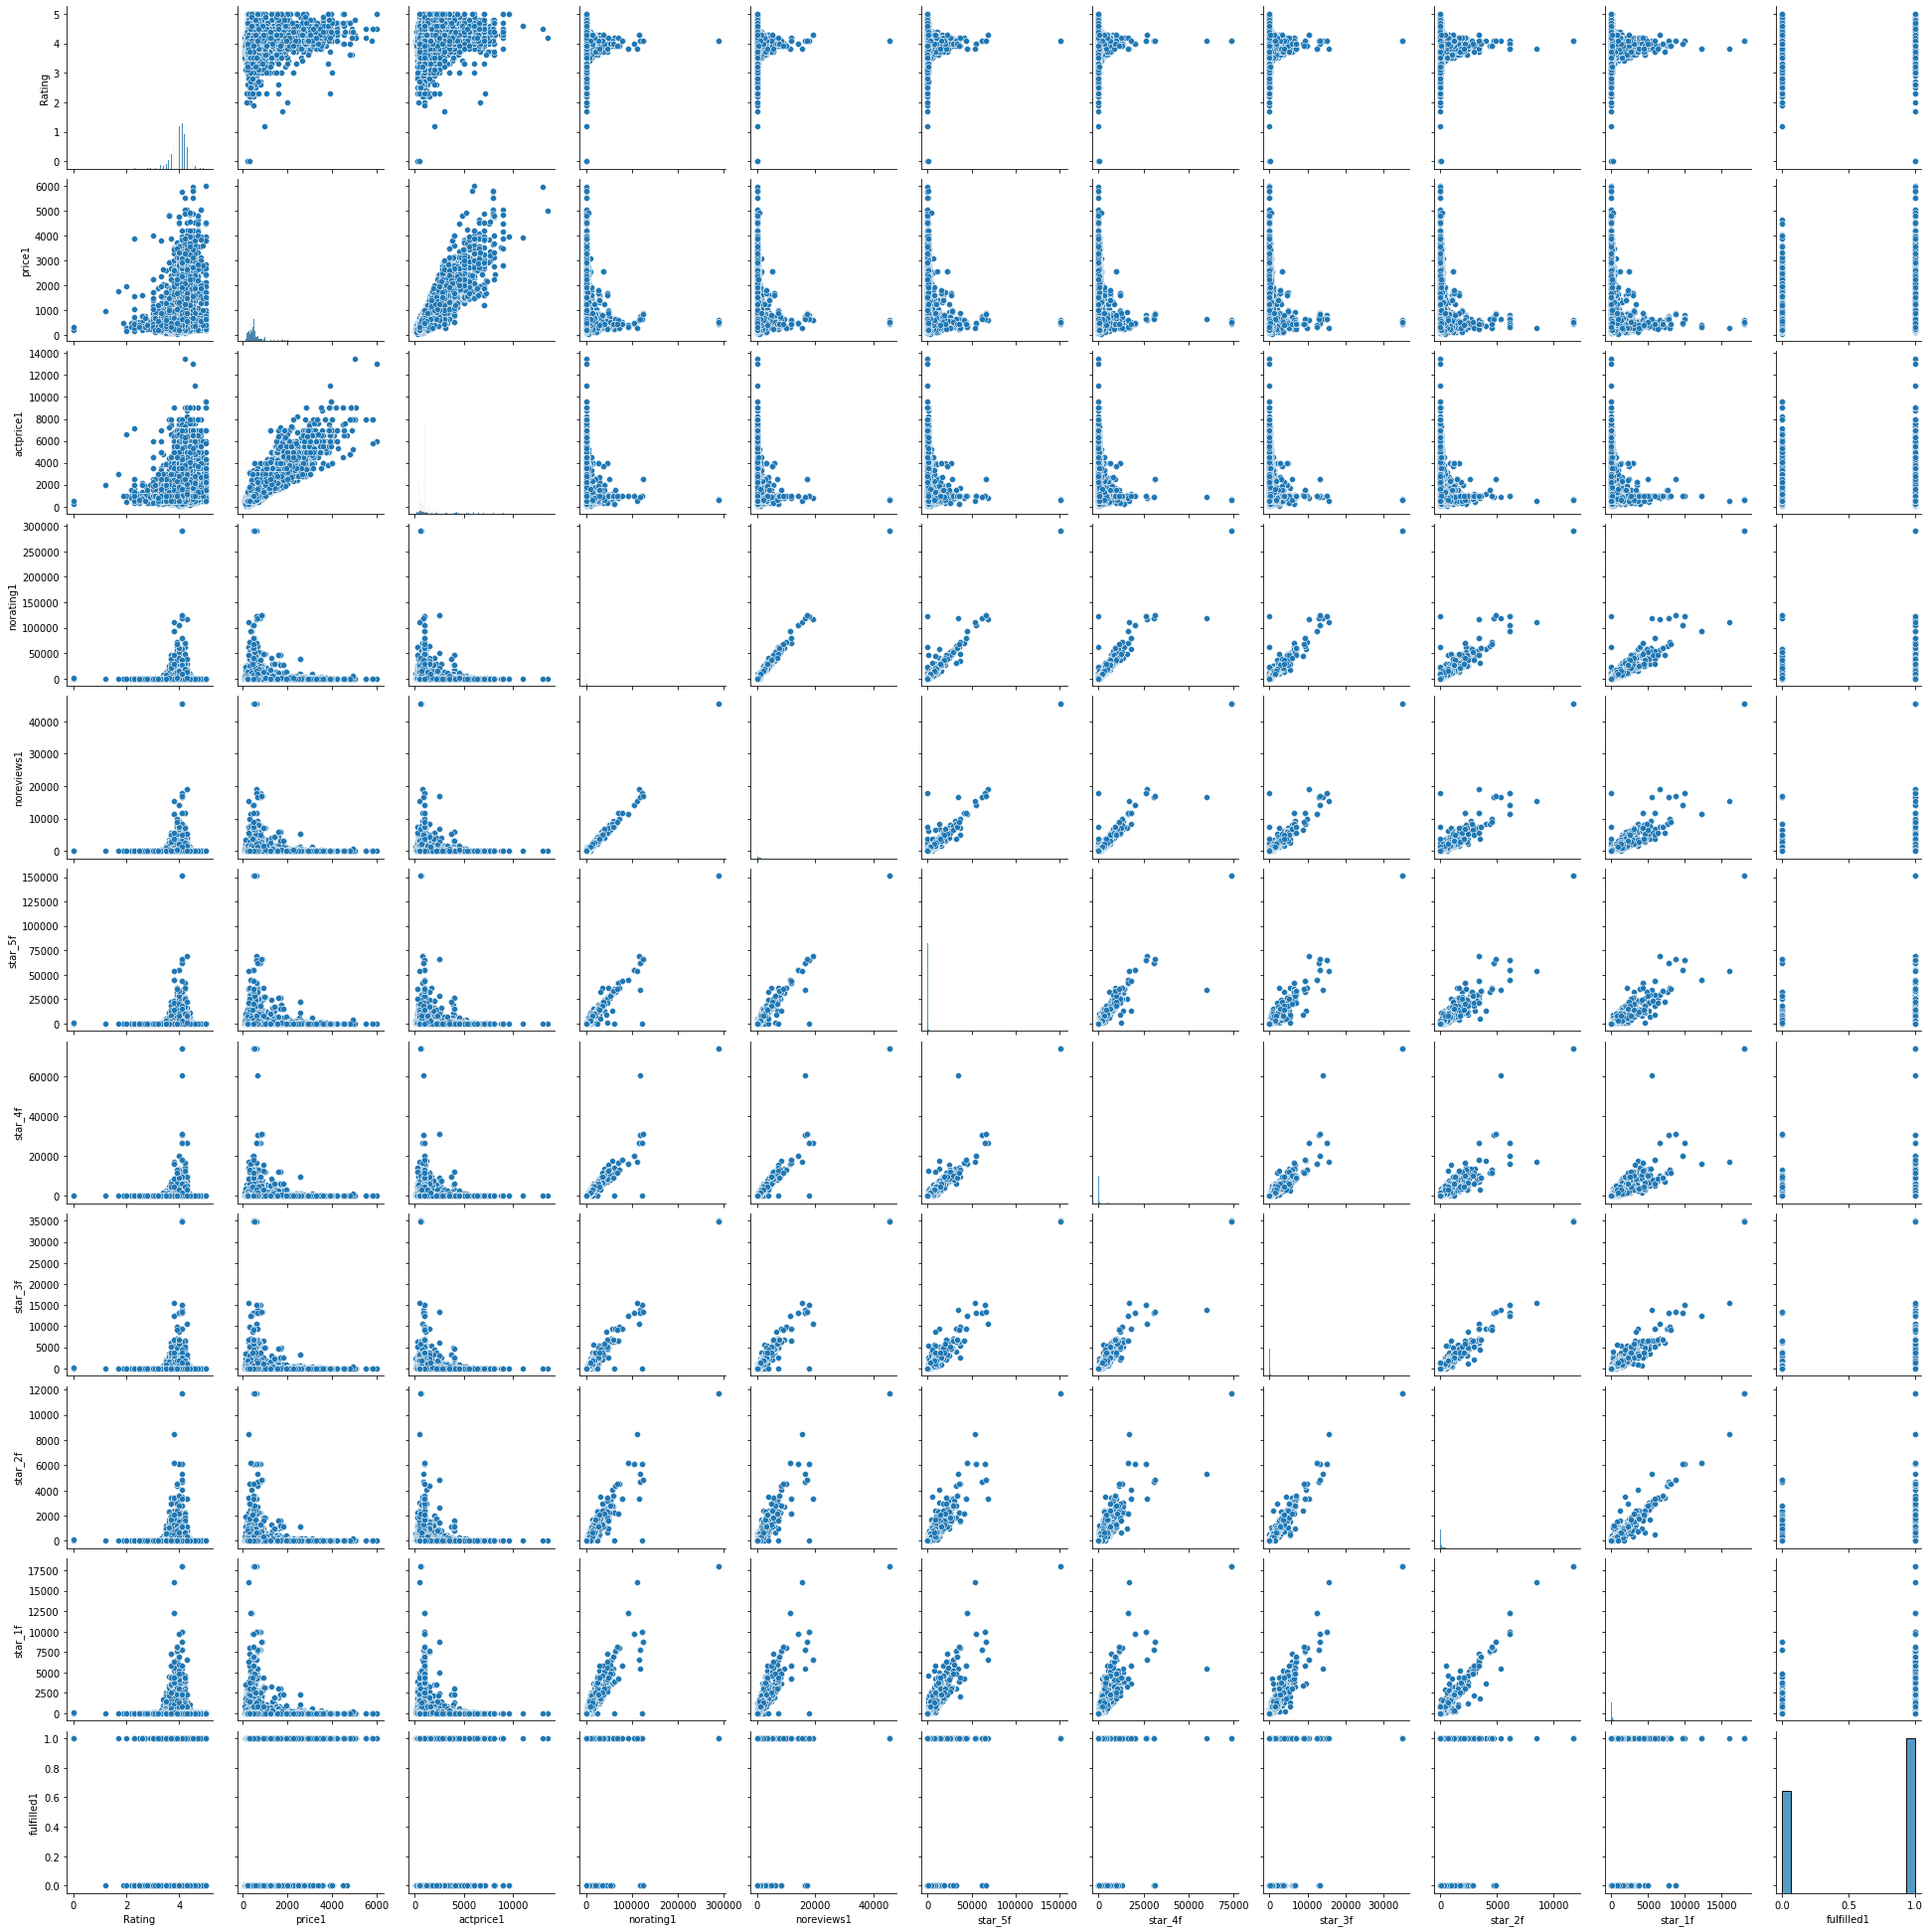

In [8]:
sns.pairplot(df)

The main conclusion I was able to make from this was that XGBRegressor is the best suited model to impute star_f columns and linear regression is best suited model for imputing noreviews1 from norating1

Also distribution of data from all star_f columns is identical nature, this can also be inferred from the correlation matrix which shows that all star_f columns, norating1 and noreview1 is highly correlated data

# Handling Nulls

In [9]:
df.isnull().sum()

title           0
Rating          0
maincateg     526
platform        0
price1          0
actprice1       0
norating1     678
noreviews1    578
star_5f       588
star_4f       539
star_3f       231
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

### Maincateg Null Values

In [10]:
df['maincateg'].unique()

array(['Women', 'Men', nan], dtype=object)

In [11]:
df[df['maincateg'].isnull()].tail()

,title,Rating,maincateg,platform,price1,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
15536,Slides,4.5,NaN,Flipkart,499,799,NaN,1.0,23.0,NaN,1.0,1,2,0
15570,Women Multicolor Bellies Sandal,3.7,NaN,Flipkart,501,999,NaN,NaN,NaN,141.0,111.0,75,128,1
15583,Jutis For Men (Black),3.7,NaN,Flipkart,494,499,NaN,NaN,22.0,NaN,4.0,4,8,0
15674,Zod Runner V3 Wn s IDP Running Shoes For Women...,4.3,NaN,Flipkart,1699,3999,NaN,NaN,NaN,NaN,268.0,102,140,1
15709,Enzo Beta Wn's Basketball Shoes For Women (Br...,3.9,NaN,Flipkart,1701,5499,NaN,NaN,NaN,NaN,6.0,2,10,1


If maincateg is not given we can still figure out Men/Women from title

In [12]:
df.loc[df['title'].str.upper().str.contains('WOMEN') & df['maincateg'].isnull(), 'maincateg'] = 'Women'
df.loc[df['title'].str.upper().str.contains('MEN') & df['maincateg'].isnull(), 'maincateg'] = 'Men'
df['maincateg'].isnull().sum()

57

In [13]:
df[df['maincateg'].isnull()]

,title,Rating,maincateg,platform,price1,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
91,Slippers,3.6,NaN,Flipkart,213,249,NaN,NaN,NaN,NaN,466.0,281,476,1
228,Slippers,3.8,NaN,Flipkart,141,499,NaN,23.0,71.0,NaN,22.0,14,17,0
728,Slides,3.7,NaN,Flipkart,419,998,NaN,4.0,NaN,NaN,NaN,3,4,1
842,Slides,3.9,NaN,Flipkart,2110,2995,NaN,1.0,NaN,NaN,0.0,1,1,1
1056,Flip Flops,3.8,NaN,Flipkart,326,499,NaN,NaN,NaN,21.0,NaN,2,10,0
1095,Flip Flops,4.2,NaN,Flipkart,1047,1799,NaN,7.0,NaN,NaN,5.0,3,2,1
1283,Slippers,4.4,NaN,Flipkart,599,1199,NaN,17.0,NaN,NaN,NaN,3,2,1
1288,Slippers,4.3,NaN,Flipkart,599,1199,NaN,NaN,NaN,NaN,NaN,3,5,1
1646,Flip Flops,3.4,NaN,Flipkart,498,1497,NaN,7.0,NaN,NaN,8.0,8,23,1
2029,Flip Flops,3.6,NaN,Flipkart,99,499,NaN,14.0,NaN,NaN,NaN,6,8,0


The remaining of the null values in maincateg are unisexual products like slippers

In [14]:
df.loc[df['maincateg'].isnull(), 'maincateg'] = 'Unisex'
print(df['maincateg'].isnull().sum())
print(df['maincateg'].unique())

0
['Women' 'Men' 'Unisex']


### star_f and norating1 Null Values

I decided to impute the null values of star_f columns using XGBRegressor Model 

For norating1 column (number of ratings) i filled null values using sum of all star_f columns

In [15]:
lrm5 = XGBRegressor()
X_lrm5 = np.array(df.loc[df['star_5f'].notna(), ['Rating', 'star_2f', 'star_1f']])
y_lrm5 = np.array(df[df['star_5f'].notna()]['star_5f'])
lrm5.fit(X_lrm5, y_lrm5)

df.loc[df['star_5f'].isnull(), 'star_5f'] = lrm5.predict(np.array(df.loc[df['star_5f'].isnull(), ['Rating', 'star_2f', 'star_1f']]))

In [16]:
lrm4 = XGBRegressor()
X_lrm4 = np.array(df.loc[df['star_4f'].notna(), ['Rating', 'star_2f', 'star_1f']])
y_lrm4 = np.array(df[df['star_4f'].notna()]['star_4f'])
lrm4.fit(X_lrm4, y_lrm4)

df.loc[df['star_4f'].isnull(), 'star_4f'] = lrm4.predict(np.array(df.loc[df['star_4f'].isnull(), ['Rating', 'star_2f', 'star_1f']]))

In [17]:
lrm3 = XGBRegressor()
X_lrm3 = np.array(df.loc[df['star_3f'].notna(), ['Rating', 'star_2f', 'star_1f']])
y_lrm3 = np.array(df[df['star_3f'].notna()]['star_3f'])
lrm3.fit(X_lrm3, y_lrm3)

df.loc[df['star_3f'].isnull(), 'star_3f'] = lrm3.predict(np.array(df.loc[df['star_3f'].isnull(), ['Rating', 'star_2f', 'star_1f']]))

In [18]:
df.loc[df['norating1'].isnull(), 'norating1'] = df.loc[df['norating1'].isnull(), 'star_5f'] + df.loc[df['norating1'].isnull(), 'star_4f'] + df.loc[df['norating1'].isnull(), 'star_3f'] + df.loc[df['norating1'].isnull(), 'star_2f'] + df.loc[df['norating1'].isnull(), 'star_1f']

### noreviews1 Null Values

<AxesSubplot:xlabel='norating1', ylabel='noreviews1'>

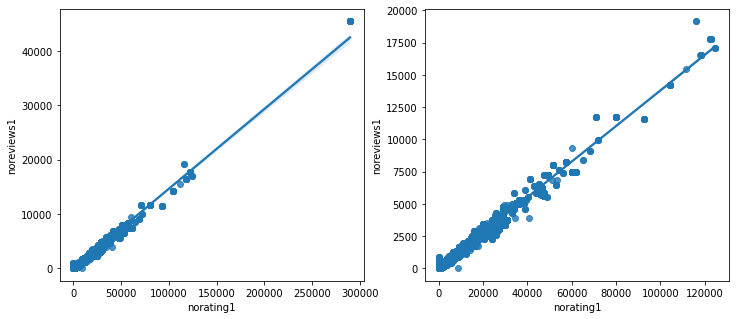

In [19]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
sns.regplot(df['norating1'], df['noreviews1'])

plt.subplot(1,2,2)
sns.regplot(df[df['noreviews1'] < 20000]['norating1'], df[df['noreviews1'] < 20000]['noreviews1'])

Judging the plot between norating1 and noreviews1, i decided to use linear regression model to impute noreviews1 null values

In [20]:
lrm = LinearRegression()
X_lrm = df[df['noreviews1'] < 20000]['norating1'].values.reshape(-1,1)
y_lrm = df[df['noreviews1'] < 20000]['noreviews1'].values
lrm.fit(X_lrm, y_lrm)

df.loc[df['noreviews1'].isnull(), 'noreviews1'] = lrm.predict(df[df['noreviews1'].isnull()]['norating1'].values.reshape(-1,1))

In [21]:
df.isnull().sum()

title         0
Rating        0
maincateg     0
platform      0
price1        0
actprice1     0
norating1     0
noreviews1    0
star_5f       0
star_4f       0
star_3f       0
star_2f       0
star_1f       0
fulfilled1    0
dtype: int64

# Plotting Data

In [22]:
data.columns

Index(['title', 'Rating', 'maincateg', 'platform', 'price1', 'actprice1',
       'Offer %', 'norating1', 'noreviews1', 'star_5f', 'star_4f', 'star_3f',
       'star_2f', 'star_1f', 'fulfilled1'],
      dtype='object')

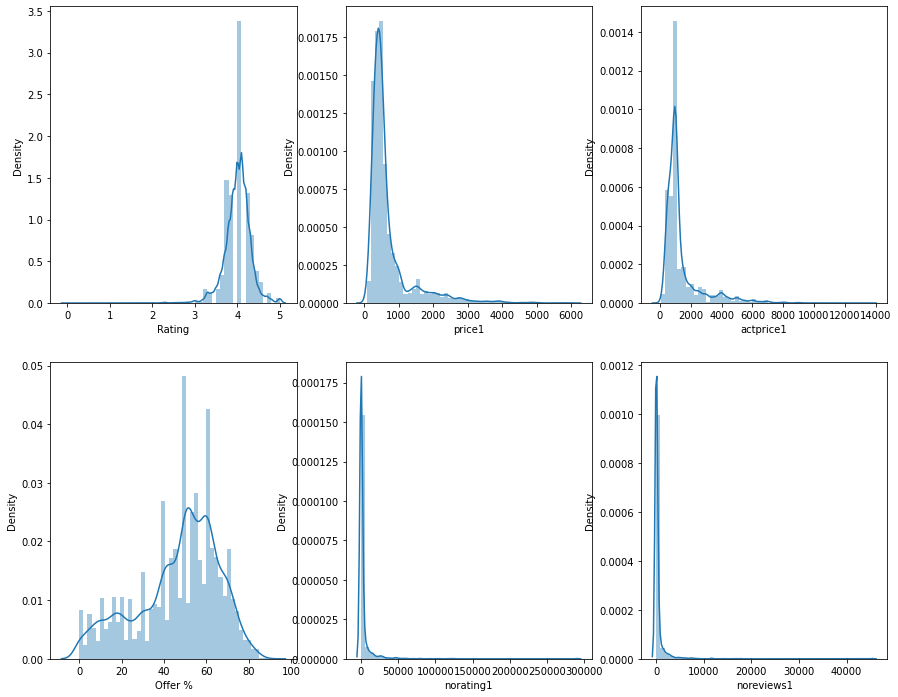

In [23]:
plt.figure(figsize=(15,12))

plt_cols = ['Rating', 'price1', 'actprice1', 'Offer %', 'norating1', 'noreviews1']

# I didnt plot the star_f columns because they are highly correlated to norating1 and noreviews1 
# columns & have similar distributions to them

k=1
for i in plt_cols:
    plt.subplot(2,3,k)
    sns.distplot(data[i])
    k=k+1

- Distribution of Rating column is very close to a normal distibution
- The distribution of norating1 and noreviews1 column is heavily skewed, this is because of a continuous distribution of outliers from 5000-30000 while most of the data is in less than 1000 range
- actprice1 and price1 are not 'perfect' normal distributions and are slightly skewed
- Offer % is a column that will not be used as it is not provided in testing data, its just easier to understand

Note the count axis in all 3 plots


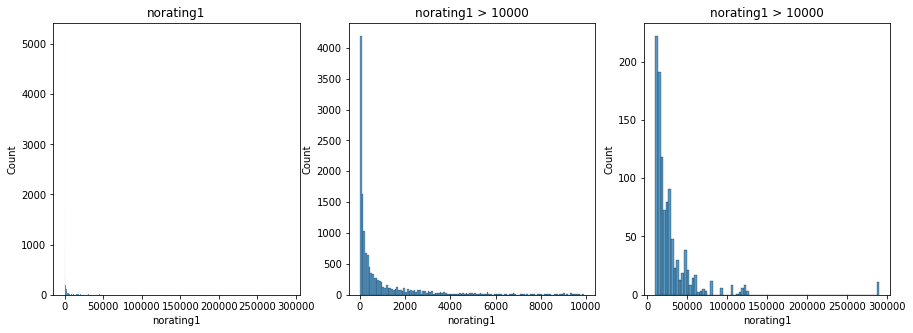

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('norating1')
sns.histplot(data['norating1'])

plt.subplot(1,3,2)
plt.title('norating1 > 10000')
sns.histplot(data[data['norating1'] < 10000]['norating1'])

plt.subplot(1,3,3)
plt.title('norating1 > 10000')
sns.histplot(data[data['norating1'] > 10000]['norating1'])

print('Note the count axis in all 3 plots')

I could not think of any good changes to implement on the norating1 and noreviews1 column because this sort of distribution is expected(i could be wrong) and i cannot drop data as outliers, as there will be products that sell more and have more number of reviews & rating but that does not tell us much about quality of product or expected offer % on that product, it only tells that this product is well marketed and sold more units

<AxesSubplot:title={'center':'Discounted Price'}, xlabel='price1', ylabel='Density'>

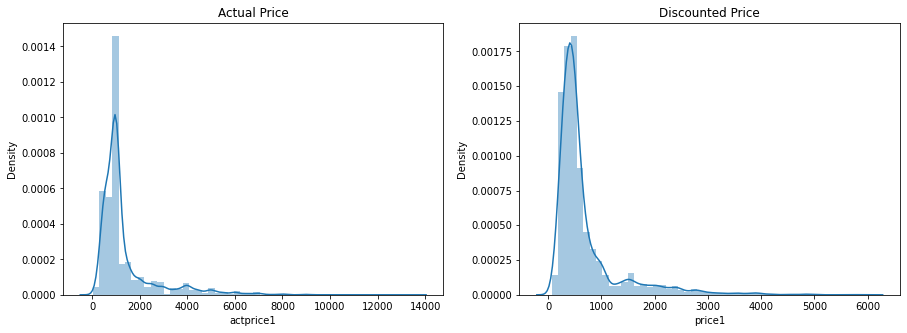

In [25]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Actual Price')
sns.distplot(data['actprice1'])

plt.subplot(1,2,2)
plt.title('Discounted Price')
sns.distplot(data['price1'])

Looking at the distribution of these 2 columns, I decided to try making actprice1 column more normally distributed as that would help the model and would also match the distribution of output column price1 better

To start I made some qq plots and tried some feature transformations

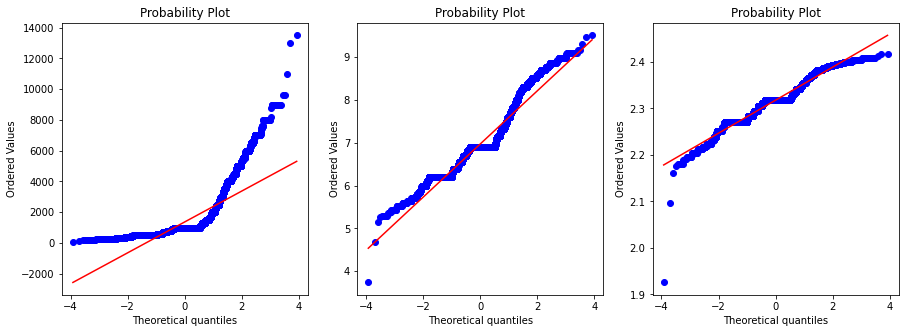

In [26]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
stats.probplot(data['actprice1'],plot=pylab)   # No Transformation

plt.subplot(1,3,2)
stats.probplot(np.log(data['actprice1']),plot=pylab)   # Log Transformation

var, _ = stats.boxcox(data['actprice1'])
plt.subplot(1,3,3)
stats.probplot(var,plot=pylab)   # BoxCox Transformation

plt.show()

- Based on these transformations I added logprice column by taking log of actprice1 column
- I didnt drop actprice1 beacuse price1 column is generated by transforming actprice1

In [27]:
df['logprice'] = np.log(df['actprice1'])
# Improved RMSE from 177 to 169

# Making Features from title 

So my initial idea was to look for words that are related to offers/discounts

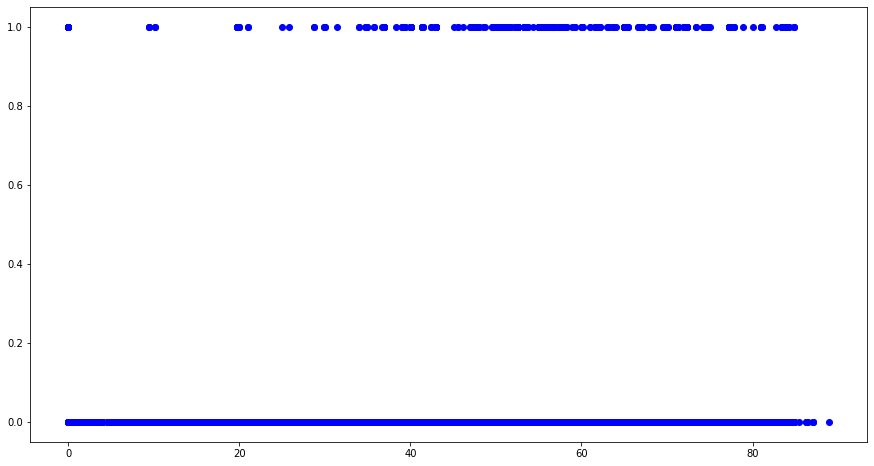

In [28]:
plt.figure(figsize=(15,8))
plt.plot(data['Offer %'], data['title'].str.upper().str.contains('COMBO').astype(int), 'bo')

From this plot, it seems like product listings with the word 'Combo' are more likely to give high offers, so i added a column combo telling whether the title contains the word combo 

In [29]:
df['combo'] = df['title'].str.upper().str.contains('COMBO').astype(int)

Using title column I also divided the data into different shoe types like Shoe/Sandal/Sneaker/Chappal

In [30]:
df['sandal'] = df['title'].str.upper().str.contains('SANDAL').astype(int)
df['sneaker'] = df['title'].str.upper().str.contains('SNEAKER').astype(int)       
df['shoe'] = df['title'].str.upper().str.contains('SHOE').astype(int)
df['chappal'] = (df['title'].str.upper().str.contains('SLIPPERS') | df['title'].str.upper().str.contains('SLIDES') | df['title'].str.upper().str.contains('FLIP FLOPS')).astype(int)

Ultimately I decided that to extract all data from title by looking at most frequent words of title

In [31]:
# 100 most frequent words in title column

from collections import Counter

arr = []
for i in data['title'].str.split(' '):
    arr += i

c = Counter(arr)    
c_list = c.most_common(100)
c_list

# words = []

# for wd in  c_list:
#     words.append(wd[0])
        
# print(words)

[('For', 10241),
 ('Sandal', 4194),
 ('Shoes', 4163),
 ('Women', 3976),
 ('Running', 2024),
 ('Sneakers', 1806),
 ('Men', 1580),
 ('Black', 1499),
 ('Boots', 1471),
 ('Casual', 1454),
 ('Men\xa0\xa0(Black)', 1454),
 ('Bellies', 1093),
 ('for', 1080),
 ('Jutis', 1073),
 ('Flats', 1054),
 ('Heels', 1008),
 ('Women\xa0\xa0(Black)', 967),
 ('Flip', 894),
 ('Wedges', 875),
 ('Flops', 843),
 ('Stylish', 830),
 ('Walking', 775),
 ('Slip', 711),
 ('Slippers', 679),
 ('On', 663),
 ('Sports', 653),
 ('&', 639),
 ('Slides', 618),
 ('Casuals', 614),
 ('shoes', 593),
 ('Girls', 592),
 ('Women\xa0\xa0(Pink)', 578),
 ('Men\xa0\xa0(Brown)', 529),
 ('|', 505),
 ('Leather', 469),
 ('of', 458),
 ('Mojaris', 458),
 ('Pink', 455),
 ("Men's", 445),
 ('Women\xa0\xa0(Multicolor)', 442),
 ('Lace', 435),
 ('Brown', 435),
 ('Women\xa0\xa0(White)', 432),
 ('and', 430),
 ('Combo', 403),
 ('Grey', 378),
 ('Blue', 371),
 ('Pack', 361),
 ('Women\xa0\xa0(Grey)', 360),
 ('Men\xa0\xa0(Blue)', 356),
 ('High', 351),
 ('La

I then created a list called sp_cols of 100 most frequent words and dropped words like:

    - Un-important words like for, of, on....
    - Repeated things like men/women, combo, sandals....
    - Non descriptive words like Latest/Stylish/Perfect that dont describe the product

In [32]:
# # sp_cols = ['Running', 'Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Walking', 'Slip', 'Sports', 'Casuals', 'Grey', 'Blue', 'Beige', 'Red', 'Brown']
ver_1 = ['Running','Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Stylish', 'Walking', 'Slip', 'Sports', 'Girls', 'Leather', 'Mojaris', 'Pink', 'Lace', 'Brown', 'Combo', 'Grey', 'Blue', 'Pack', 'High', 'Latest', 'Loafers', 'Beige', 'Comfortable', 'White', 'Red', 'Ethnic', 'Multicolor', 'Wear', 'Formal', 'Tan', 'Synthetic', 'Gold', 'Canvas', 'Party', 'Perfect', 'Training', 'IDP', 'Gym', 'Partywear', 'Jutti', 'Ankle', 'Shoe', 'New', 'Fashionable', 'Navy', 'Design', 'Lightweight', 'Derby', ]
ver_colour = ['Black', 'Pink', 'Brown', 'Grey', 'Blue', 'Beige', 'White', 'Red', 'Multicolor','Tan', 'Gold', 'Navy']
ver_2 = ['Running','Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Stylish', 'Walking', 'Slip', 'Sports', 'Girls', 'Leather', 'Mojaris', 'Pink', 'Lace', 'Brown', 'Grey', 'Blue', 'Pack', 'Loafers', 'Beige', 'White', 'Red', 'Ethnic', 'Multicolor', 'Formal', 'Tan', 'Synthetic', 'Gold', 'Canvas', 'Party', 'Training', 'IDP', 'Gym', 'Jutti', 'Ankle', 'New', 'Navy', 'Lightweight', 'Derby']


sp_cols = ver_2 

for cl in sp_cols:
    df[cl] = df['title'].str.upper().str.contains(cl.upper()).astype(int)

In [33]:
# Just to check that all strings had correct spelling in list
for cl_ck in sp_cols:
    if df[cl_ck].sum() == 0:
        print(cl_ck)

In [34]:
df.drop('title', axis='columns', inplace=True)

In [35]:
# Reorganazing columns

df = df[(['Rating', 'norating1',
       'noreviews1', 'star_5f', 'star_4f', 'star_3f', 'star_2f', 'star_1f',
       'actprice1', 'price1', 'fulfilled1', 'combo', 'sandal', 'sneaker', 'shoe', 'chappal', 'logprice', 'maincateg', 'platform']) + sp_cols]

df.head()

,Rating,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,actprice1,price1,...,Party,Training,IDP,Gym,Jutti,Ankle,New,Navy,Lightweight,Derby
0,3.9,38.0,7.0,17.0,9.0,6.0,3,3,999,698,...,0,0,0,0,0,0,0,0,0,0
1,3.8,531.0,69.0,264.0,92.0,73.0,29,73,1999,999,...,0,0,0,0,0,0,0,0,0,0
2,4.4,17.0,4.0,11.0,3.0,2.0,1,0,4999,2749,...,0,0,0,0,0,0,0,0,0,0
3,4.2,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,724,518,...,0,0,0,0,0,0,0,0,0,0
4,3.9,77.0,3.0,35.0,21.0,7.0,7,7,2299,1379,...,0,0,0,0,0,0,0,0,0,0


# Model

## Pipeline

In [36]:
col_enc = make_column_transformer((OneHotEncoder(), ['maincateg', 'platform']), remainder='passthrough')

In [37]:
df.shape

(15730, 62)

In [38]:
df.head()

,Rating,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,actprice1,price1,...,Party,Training,IDP,Gym,Jutti,Ankle,New,Navy,Lightweight,Derby
0,3.9,38.0,7.0,17.0,9.0,6.0,3,3,999,698,...,0,0,0,0,0,0,0,0,0,0
1,3.8,531.0,69.0,264.0,92.0,73.0,29,73,1999,999,...,0,0,0,0,0,0,0,0,0,0
2,4.4,17.0,4.0,11.0,3.0,2.0,1,0,4999,2749,...,0,0,0,0,0,0,0,0,0,0
3,4.2,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,724,518,...,0,0,0,0,0,0,0,0,0,0
4,3.9,77.0,3.0,35.0,21.0,7.0,7,7,2299,1379,...,0,0,0,0,0,0,0,0,0,0


In [39]:
X = df.drop('price1', axis='columns')
y = df['price1']

## Random Forest

In [40]:
# Model after GridSearchCV hyperparametertuning

In [41]:
rfr = RandomForestRegressor(n_estimators = 225, bootstrap = False, max_features = 7, random_state=2)
pp_rfr = make_pipeline(col_enc, rfr)

rfr_scores = -1*cross_val_score(pp_rfr, X, y, cv=5, scoring='neg_root_mean_squared_error')
rfr_scores.mean()

172.34461792719358

In [42]:
rfr_scores

array([173.10584126, 185.47647569, 171.77805815, 170.36309811,
       160.99961642])

In [43]:
from sklearn.model_selection import train_test_split

In [66]:
x_train, x_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 69)

In [67]:
pp_rfr.fit(x_train, y_train)
preds = pp_rfr.predict(x_test)

In [73]:
from sklearn.metrics import r2_score
print(r2_score(y_test, preds))


0.92100175551494


# Test Data

In [44]:
dft = pd.read_csv(r"C:\Users\user\OneDrive - iitkgp.ac.in\Desktop\SQL\test.csv")
dft_id = dft['id']
dft.isnull().sum()

id              0
title           0
Rating        203
maincateg      67
platform        0
actprice1       0
norating1       0
noreviews1      0
star_5f        68
star_4f         0
star_3f         0
star_2f         0
star_1f       186
fulfilled1      0
dtype: int64

Handled maincateg and star_f null values same way as done with training data

In [45]:
dft.loc[dft['title'].str.upper().str.contains('WOMEN') & dft['maincateg'].isnull(), 'maincateg'] = 'Women'
dft.loc[dft['title'].str.upper().str.contains('MEN') & dft['maincateg'].isnull(), 'maincateg'] = 'Men'
dft.loc[dft['maincateg'].isnull(), 'maincateg'] = 'Unisex'

In [46]:
lrm5t = XGBRegressor()
X_lrm5t = np.array(dft.loc[dft['star_5f'].notna(), ['Rating', 'star_4f', 'star_3f', 'star_2f']])
y_lrm5t = np.array(dft[dft['star_5f'].notna()]['star_5f'])
lrm5t.fit(X_lrm5t, y_lrm5t)

dft.loc[dft['star_5f'].isnull(), 'star_5f'] = lrm5t.predict(np.array(dft.loc[dft['star_5f'].isnull(), ['Rating', 'star_4f', 'star_3f', 'star_2f']]))

In [47]:
lrm1t = XGBRegressor()
X_lrm1t = np.array(dft.loc[dft['star_1f'].notna(), ['Rating', 'star_4f', 'star_3f', 'star_2f']])
y_lrm1t = np.array(dft[dft['star_1f'].notna()]['star_1f'])
lrm1t.fit(X_lrm1t, y_lrm1t)

dft.loc[dft['star_1f'].isnull(), 'star_1f'] = lrm1t.predict(np.array(dft.loc[dft['star_1f'].isnull(), ['Rating', 'star_4f', 'star_3f', 'star_2f']]))

Training data didnt have Rating null values, handled this by taking weighted avg of star_f columns

In [48]:
dft[dft['Rating'].isnull()]

,id,title,Rating,maincateg,platform,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
35,17580,Women Beige Heels Sandal,NaN,Women,Flipkart,999,473,68,210.401382,119,45,16,22.735022,1
84,11588,Royal Jutis For men Mojaris For Men (Black),NaN,Men,Flipkart,899,41,7,22.000000,9,3,1,6.000000,0
88,15449,Flip Flops,NaN,Unisex,Flipkart,499,3073,401,1248.000000,517,510,274,620.291992,1
90,12342,"Men Black, Blue Sports Sandal",NaN,Men,Flipkart,2499,52,5,31.581591,13,6,4,5.403719,1
91,9065,Sneakers For Men (Black),NaN,Men,Flipkart,999,2465,274,1408.000000,407,258,137,260.374390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5164,9552,Mojaris Jutis For Men (Black),NaN,Men,Flipkart,499,11,2,8.000000,0,0,1,1.602450,0
5177,16621,Women Black Flats Sandal,NaN,Women,Flipkart,599,1057,94,632.498840,229,172,79,131.182556,1
5179,9466,Flip Flops,NaN,Men,Flipkart,499,5227,686,2539.000000,1019,687,344,571.359985,0
5188,3575,Ethnic Mule For Women (Pink),NaN,Women,Flipkart,699,53,8,30.000000,9,7,2,4.622891,0


In [49]:
dft.loc[dft['Rating'].isnull(), 'Rating'] = ((dft.loc[dft['Rating'].isnull(), 'star_5f'])*5 + (dft.loc[dft['Rating'].isnull(), 'star_4f'])*4 + (dft.loc[dft['Rating'].isnull(), 'star_3f'])*3 + (dft.loc[dft['Rating'].isnull(), 'star_2f'])*2 + (dft.loc[dft['Rating'].isnull(), 'star_1f'])*1)/((dft.loc[dft['Rating'].isnull(), 'star_5f']) + (dft.loc[dft['Rating'].isnull(), 'star_4f']) + (dft.loc[dft['Rating'].isnull(), 'star_3f']) + (dft.loc[dft['Rating'].isnull(), 'star_2f']) + (dft.loc[dft['Rating'].isnull(), 'star_1f']))

In [50]:
dft[dft['Rating'].isnull()]

,id,title,Rating,maincateg,platform,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1


In [51]:
dft.loc[dft['Rating'].isnull(), 'Rating'] = 0

Completing Feature Transformations on testing data

In [52]:
dft['combo'] = dft['title'].str.upper().str.contains('COMBO').astype(int)

In [53]:
dft['sandal'] = dft['title'].str.upper().str.contains('SANDAL').astype(int)
dft['sneaker'] = dft['title'].str.upper().str.contains('SNEAKER').astype(int)
dft['shoe'] = dft['title'].str.upper().str.contains('SHOE').astype(int)
dft['chappal'] = (dft['title'].str.upper().str.contains('SLIPPERS') | dft['title'].str.upper().str.contains('SLIDES') | dft['title'].str.upper().str.contains('FLIP FLOPS')).astype(int)

In [54]:
dft['logprice'] = np.log(dft['actprice1'])
dft.head()

,id,title,Rating,maincateg,platform,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,combo,sandal,sneaker,shoe,chappal,logprice
0,2242,Casuals For Men (Blue),3.8,Men,Flipkart,999,27928,3543,14238.0,4295,3457,1962,3976.0,1,0,0,0,0,0,6.906755
1,20532,Women Black Flats Sandal,3.9,Women,Flipkart,499,3015,404,1458.0,657,397,182,321.0,1,0,1,0,0,0,6.212606
2,10648,Women Gold Wedges Sandal,3.9,Women,Flipkart,999,449,52,229.0,70,71,33,46.0,1,0,1,0,0,0,6.906755
3,20677,Men's Height Increasing High Heel Formal Party...,3.9,Men,Flipkart,2999,290,40,141.0,51,49,17,32.0,1,0,0,0,0,0,8.006034
4,12593,Loafers For Men (Tan),3.9,Men,Flipkart,999,2423,326,1265.0,414,293,143,308.0,0,0,0,0,0,0,6.906755


In [55]:
for cl in sp_cols:
    dft[cl] = dft['title'].str.upper().str.contains(cl.upper()).astype(int)

In [56]:
dft.drop(['id','title'], axis='columns', inplace=True)
dft.shape

(5244, 61)

In [57]:
pp_rfr.fit(X, y)
preds = pp_rfr.predict(dft)
df_sub = pd.DataFrame({'id':dft_id.values, 'price1':preds})

In [59]:
#from sklearn

In [60]:
df_sub.to_csv('submission.csv', index=False)

# Failed Idea dealing with multiple listings

In [61]:
data['title'].nunique()

4782

So out of 15.7k product listing ther are only 4.7k unique listings, lot of duplicates

In [62]:
cr = Counter(data['title'])    
cr_list = cr.most_common(30)
cr_list

[('Flip Flops', 495),
 ('Slides', 433),
 ('Slippers', 356),
 ('Women Black Heels Sandal', 341),
 ('Women Black Wedges Sandal', 252),
 ('Women Black Flats Sandal', 216),
 ('Boots For Women\xa0\xa0(Black)', 149),
 ('Men Black Sandal', 108),
 ('Slip On For Men\xa0\xa0(Black)', 103),
 ('Women Pink Flats Sandal', 100),
 ('Women Beige Heels Sandal', 92),
 ('Women Multicolor Flats Sandal', 87),
 ('Men Brown Sandal', 84),
 ('Jutis For Women\xa0\xa0(Multicolor)', 83),
 ('Women Brown Wedges Sandal', 82),
 ('Women Pink Heels Sandal', 76),
 ('Women Gold Wedges Sandal', 72),
 ('Bellies For Women\xa0\xa0(Black)', 70),
 ('Women Beige Wedges Sandal', 68),
 ('Women Beige Flats Sandal', 66),
 ('Running Shoes For Men\xa0\xa0(Black)', 63),
 ('Jutis For Men\xa0\xa0(Black)', 63),
 ('Women Black Bellies Sandal', 62),
 ('Women Gold Heels Sandal', 61),
 ('Women Grey Flats Sandal', 61),
 ('Lace Up For Men\xa0\xa0(Black)', 61),
 ('Women Red Heels Sandal', 60),
 ('Women Brown Flats Sandal', 59),
 ('Women Grey Hee

Checking distribution of Offer % for 30 most common products and seeing if it is different from overall distribution of Offer %

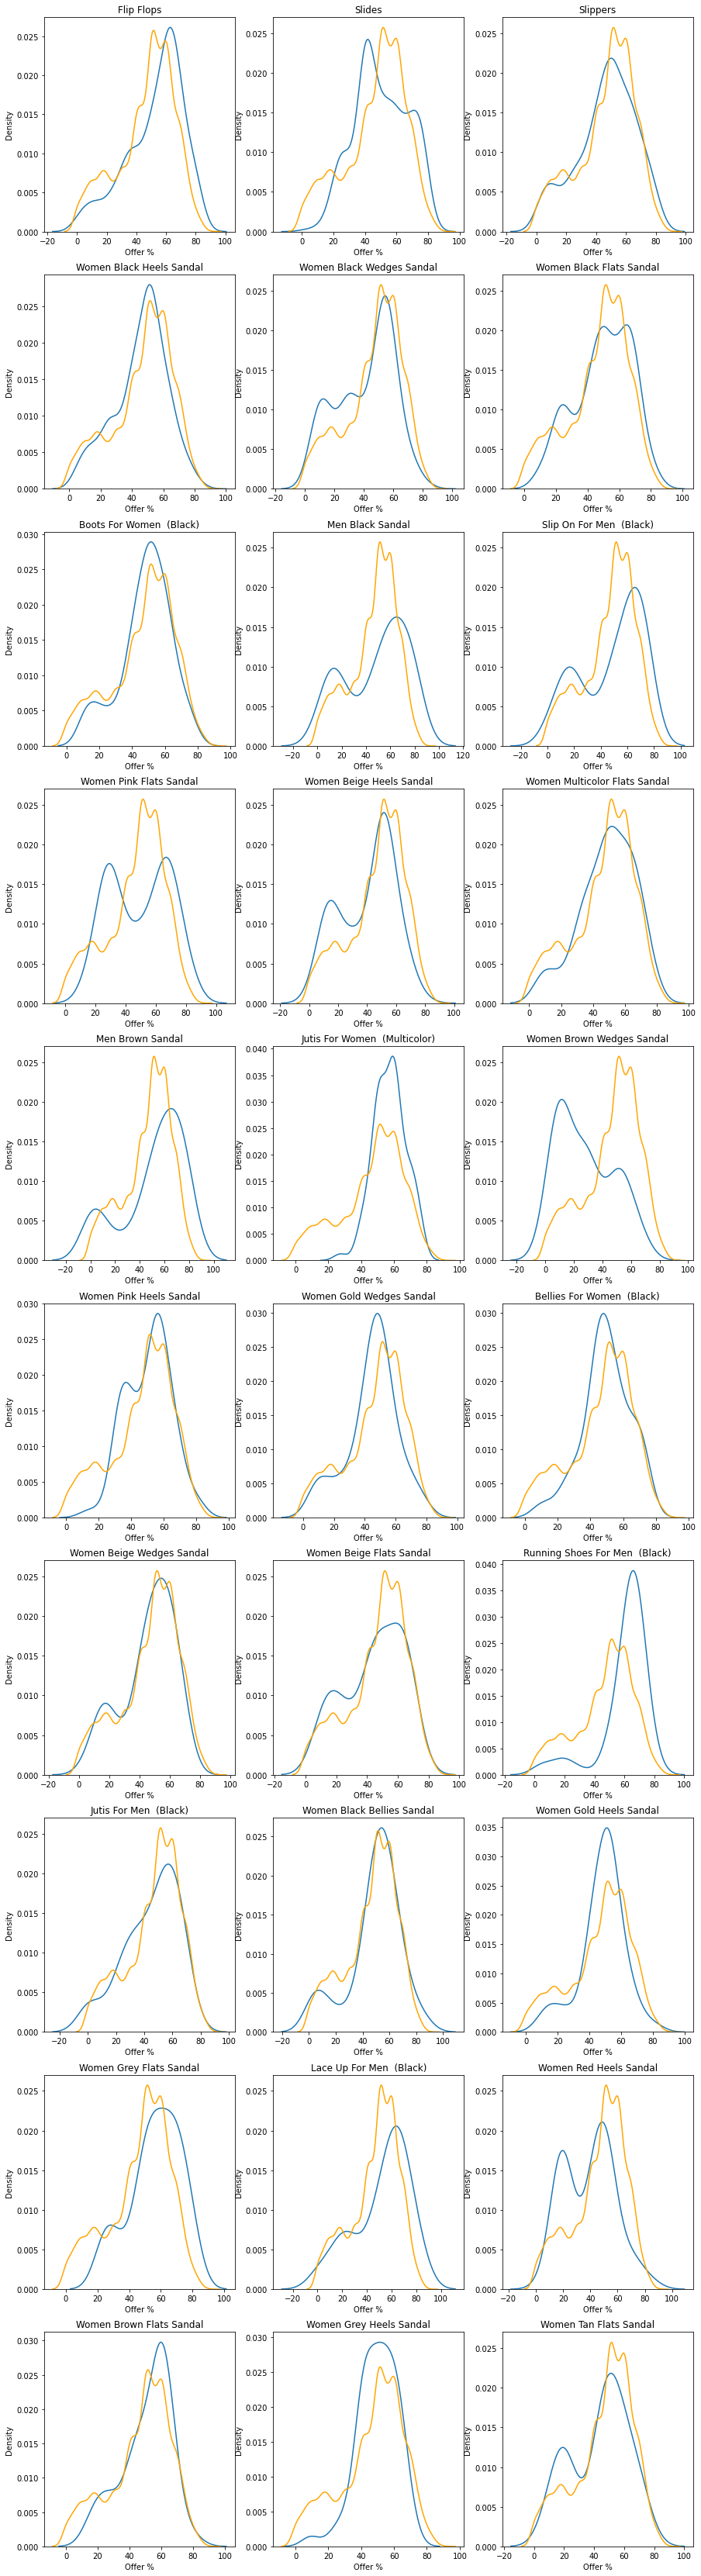

In [63]:
plt.figure(figsize=(15,60))

n = 1
for i in cr_list:
    plt.subplot(10,3,n)
    n=n+1
    plt.title(i[0])
    sns.kdeplot(data[data['title'] == i[0]]['Offer %'])
    sns.kdeplot(data['Offer %'], color='orange')
    
words = []

for wd in  cr_list:
    words.append(wd[0])

Instead of visually seeing these graphs, lets look at % overlap in the 2 graphs

In [64]:
# Code shamelessly taken from stack overflow

from scipy.stats import gaussian_kde

arr_overlap = []

for ft in words:
    x0 = data[data['title'] == ft]['Offer %']
    x1 = data['Offer %']

    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)

    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    area_inters_x = np.trapz(inters_x, x)

    arr_overlap.append(area_inters_x * 100)
#     print(f'{ft}: {area_inters_x * 100:.1f} %')
    
xd = pd.DataFrame({'Pdt':words, '%overlap':arr_overlap})  

In [65]:
xd.sort_values('%overlap')

,Pdt,%overlap
20,Running Shoes For Men (Black),58.285358
14,Women Brown Wedges Sandal,60.110585
13,Jutis For Women (Multicolor),68.576787
9,Women Pink Flats Sandal,72.195609
12,Men Brown Sandal,74.319529
28,Women Grey Heels Sandal,75.650211
26,Women Red Heels Sandal,75.699556
7,Men Black Sandal,75.722089
23,Women Gold Heels Sandal,76.322099
8,Slip On For Men (Black),78.414075


I tried to add features for products which have less overlap, meaning that their distribution is very different from overall distribution of Offer %, but this idea did not improve error at all and actually made the model perform far worse on adding 1,5,10,20 or 30 features.

I dont know if this idea is conceptually flawed or does not work with this data      ¯\_(ツ)_/¯